In [66]:
import pandas as pd
import re
import matplotlib.pyplot as plt

In [67]:
# Load data
df = pd.read_csv("/workspaces/scm-co-smart-project/data/raw/DataCoSupplyChainDataset.csv", encoding = 'latin-1' )

In [68]:
# Get basic info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

In [69]:
# Create function to rename columns' name
def rename_column(name):
    name = name.lower()
    name = re.sub(r"[^\w]+", "_", name)
    name = name.strip("_")
    return name

In [70]:
# rename columns
df.columns = [rename_column(column) for column in df.columns]

In [71]:
# rename columns: order_date_dateorders --> order_date and shipping_date_dateorders --> shipping_date
df.rename(columns={'order_date_dateorders': 'order_date'}, inplace=True)
df.rename(columns={'shipping_date_dateorders': 'shipping_date'}, inplace=True)

In [72]:
# convert date columns if needed
df['order_date'] = pd.to_datetime(df['order_date'])
df['shipping_date'] = pd.to_datetime(df['shipping_date'])

In [73]:
df.columns

Index(['type', 'days_for_shipping_real', 'days_for_shipment_scheduled',
       'benefit_per_order', 'sales_per_customer', 'delivery_status',
       'late_delivery_risk', 'category_id', 'category_name', 'customer_city',
       'customer_country', 'customer_email', 'customer_fname', 'customer_id',
       'customer_lname', 'customer_password', 'customer_segment',
       'customer_state', 'customer_street', 'customer_zipcode',
       'department_id', 'department_name', 'latitude', 'longitude', 'market',
       'order_city', 'order_country', 'order_customer_id', 'order_date',
       'order_id', 'order_item_cardprod_id', 'order_item_discount',
       'order_item_discount_rate', 'order_item_id', 'order_item_product_price',
       'order_item_profit_ratio', 'order_item_quantity', 'sales',
       'order_item_total', 'order_profit_per_order', 'order_region',
       'order_state', 'order_status', 'order_zipcode', 'product_card_id',
       'product_category_id', 'product_description', 'product_ima

In [74]:
# detect missing values
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_table = pd.DataFrame({
    "missing_values": missing_values,
    "missing_percent": missing_percent
})
missing_table = missing_table[missing_table["missing_values"] > 0]

print(missing_table)

                     missing_values  missing_percent
customer_lname                    8         0.004432
customer_zipcode                  3         0.001662
order_zipcode                155679        86.239676
product_description          180519       100.000000


In [75]:
# for customer_lname and customer_zipcode --> MCAR
df = df.dropna(subset=["customer_lname", "customer_zipcode"])

In [76]:
# for product_description - no values --> drop the whole columns
df = df.drop(['product_description'], axis = 1)

In [77]:
# for order_zipcode - optional data field --> drop the whole columns
df = df.drop(['order_zipcode'], axis = 1)

In [78]:
# Customers related columns analysis
# drop unnecessary columns
df = df.drop(['customer_email' , 'customer_password'], axis = 1)

In [79]:
# Frequency count in customer_country
df['customer_country'].value_counts()

customer_country
EE. UU.        111137
Puerto Rico     69371
Name: count, dtype: int64

In [80]:
# Find out that all customers come from the USA --> can drop the customer_country column
df = df.drop(['customer_country'], axis = 1)

In [81]:
# Frequency count in customer_state
state_count = df['customer_state'].value_counts()
state_percent = (customer_state_count / len(df)) * 100
state_table = pd.DataFrame({
    "state_count": state_count,
    "state_percent": state_percent
})

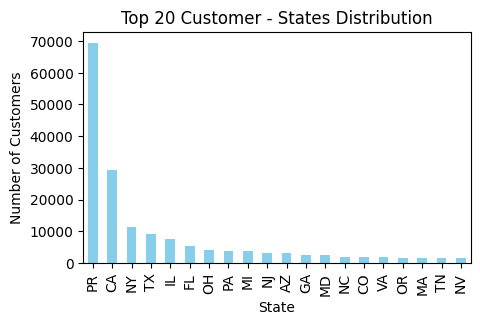

In [92]:
# Bar chart for Customer - States Distribution
plt.figure(figsize=(5,3))
state_count.head(20).plot(kind='bar', color = 'skyblue')
plt.title("Top 20 Customer - States Distribution")
plt.xlabel("State")
plt.ylabel("Number of Customers")
plt.show()

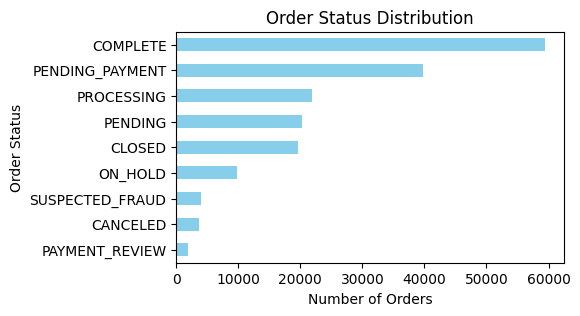

In [90]:
# Order related columns analysis

# order_status
df['order_status'].value_counts()
order_status_count = df['order_status'].value_counts()

# bar chart for Order Status Distribution
plt.figure(figsize=(5,3))
order_status_count.plot(kind='barh', color='skyblue')
plt.title("Order Status Distribution")
plt.xlabel("Number of Orders")
plt.ylabel("Order Status")
plt.gca().invert_yaxis()
plt.show()

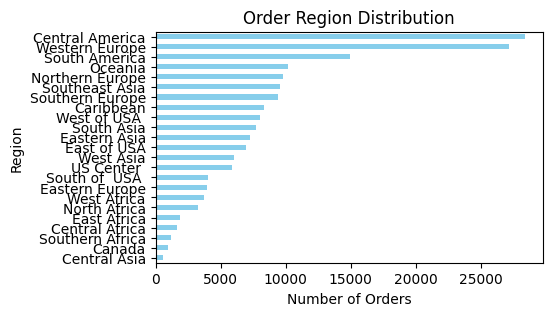

In [93]:
# order_region 
df['order_region'].value_counts()
region_count = df['order_region'].value_counts()

# bar chart for Order Region Distribution
plt.figure(figsize=(5,3))
region_count.plot(kind='barh', color='skyblue')
plt.title("Order Region Distribution")
plt.xlabel("Number of Orders")
plt.ylabel("Region")
plt.gca().invert_yaxis()  # region lớn nhất lên trên
plt.show()

In [94]:
df['order_date']

0        2018-01-31 22:56:00
1        2018-01-13 12:27:00
2        2018-01-13 12:06:00
3        2018-01-13 11:45:00
4        2018-01-13 11:24:00
                 ...        
180514   2016-01-16 03:40:00
180515   2016-01-16 01:34:00
180516   2016-01-15 21:00:00
180517   2016-01-15 20:18:00
180518   2016-01-15 18:54:00
Name: order_date, Length: 180508, dtype: datetime64[ns]